## 内容
1巡ごとに温度を下げていく

In [15]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, math, warnings
from sklearn.feature_selection import SelectKBest, f_regression

In [16]:
#valiable
warnings.resetwarnings()

warnings.simplefilter('error')
num_select=1 #変える
#T=0.1
MCMC_step=10000
T=[j for j in reversed(range(1, MCMC_step+1))] #0.00001とか
# 温度を下げていくと0が多くなるはず
# 解のかたまりが減るように

In [17]:
X = pd.read_table('training_markers.txt', header=None,  sep ='\t')# 説明変数（こっちの特徴量上位5つ取り出す）

data_yields = pd.read_table('training_yields.txt', header=None,  sep ='\t')# 目的変数
#print(data_yields)
#print(type(data_yields))

y= data_yields.T.iloc[0]
#print(y)
print(type(y))

"""
y_list = []
for i in range(len(data_yields)):
    y_list.append(data_yields.iloc[i, 0])
y = pd.Series(y_list)
print(y)
"""

num_sample = X.shape[0]#サンプル数
num_feature = X.shape[1]#特徴量の数

<class 'pandas.core.series.Series'>


In [18]:
type(X) #pandas.core.frame.DataFrame
print(X.shape) #(20, 20)

type(y) #pandas.core.series.Series
print(y.shape) #(20,)

#X

(20, 20)
(20,)


In [19]:
#特徴量の分散や同じ特徴量が存在するのかを確認

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X)

# get_supportで保持するデータのみをTrue値、そうでないものはFalse値を返します
print(sum(sel.get_support())) #20、すなわち同じ特徴量は存在していないことがわかった

20


In [20]:
def selection(num_select, X, y): #num_select個の特徴量を選択
    #print(f_regression(X,y))
    #print(np.linalg.norm(y))
    selector = SelectKBest(score_func=f_regression, k=num_select) #SelectKBest
    selector.fit(X, y)
    mask = selector.get_support() #各特徴量を選択したか否かのmaskを取得
    return mask

In [21]:
"""
0-division error occurs when all values in y are 0 or 1
reason: y = y - np.mean(y), corr /= np.linalg.norm(y)
"""
mask = selection(num_select, X, y)
print(mask)

[False False False False False False False False False False False False
 False False False False False False False  True]


In [22]:
"""
def each_energy(mask, y):
    y_list = y.values.tolist()
    energy_find_dic = {}#bestな特徴量:それを選んだときのエネルギー基準値（０となる）
    for i in range(len(mask)):
        if mask[i]==True:
            energy_find_trait = np.dot(np.array(X[:][i]).T, np.array(y_list))
            energy_find_dic[i]=energy_find_trait
    return sum(energy_find_dic.values())
"""

def each_energy(every_mask): #毎回のmaskとyが引数、合致度合いの計算を行う
    energy_trait_sum = 0
    for i in range(len(every_mask)):
        if every_mask[i]==mask[i]:
            energy_trait_sum += 1
    return energy_trait_sum #もとのyのときのmask(これをmaskとしている)との合致度合い（大きい⇒よく合致している）

In [23]:
"""
argument: s is integer
procedure: convert s from 0 to 1 or 1 to 0
return: changed value
"""
def y_renewal(s: int): #y要素の更新式
    return 1-s

In [24]:
def Montecarlo(T, num_select, MCMC_step):    
    E = [] #エネルギーの大きさの経過を記録、E_nowを入れていく
    y_go = []
    
    ori_y = y #元のデータのyを代入
    ori_y_list = ori_y.values.tolist()
    each_energy(mask) #比較対象は自身なのですべての要素が同じ⇒len(mask)= 20
    E.append(0) #each_energy(mask, ori_y) - each_energy(mask, ori_y) = 0
    y_go.append(ori_y_list) #元のyを格納
    
    
    for j in range(MCMC_step):    
        i = random.randrange(num_sample) #num_sampleから適当な整数を選ぶ
        #print(i)
        ori_yi = y[i] #ori_yiとしてとっておく
        y[i] = y_renewal(y[i])
        if np.all(np.array(y) == 1) or np.all(np.array(y) == 0):
            #print("warning occured")
            continue
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                mask_new = selection(num_select, X, y)
            except Warning:
                print("warning is here.")
                print(y)
                continue
        E_now = each_energy(mask) - each_energy(mask_new) #20 - (20以下) >= 0
        E_last = E[-1]
        #r = math.exp((b[i+1]-b[i])* (E_lists[i+1][-1]-E_lists[i][-1]))
        r = math.exp(-E_now/T[j]-(-E_last/T[j-1])) #温度付き
        R = np.random.uniform(0.0, 1.0)
        if R > r : #もしいま検討している事象が起こりにくそうだったら
            y[i] = ori_yi #新しい値は採用しない     
        else:
            E.append(E_now)
            y_list = y.values.tolist()
            y_go.append(y_list)
    return E, y_go #エネルギーのリスト、ｙのリスト

warning is here.
0     0
1     0
2     0
3     1
4     1
5     1
6     0
7     0
8     0
9     1
10    1
11    1
12    0
13    1
14    0
15    1
16    0
17    1
18    0
19    1
Name: 0, dtype: int64
warning is here.
0     1
1     1
2     1
3     0
4     0
5     0
6     0
7     1
8     0
9     1
10    0
11    0
12    1
13    1
14    0
15    1
16    1
17    1
18    0
19    1
Name: 0, dtype: int64
      0  1  2  3  4  5  6  7  8  9  ...  11  12  13  14  15  16  17  18  19  \
0     1  0  0  1  1  0  0  1  0  1  ...   0   1   0   0   0   1   1   1   1   
1     1  0  0  1  1  0  0  1  0  0  ...   0   1   0   0   0   1   1   1   1   
2     1  0  0  1  1  0  0  1  0  0  ...   1   1   0   0   0   1   1   1   1   
3     1  0  0  0  1  0  0  1  0  0  ...   1   1   0   0   0   1   1   1   1   
4     1  0  0  0  1  0  0  1  0  0  ...   1   1   0   0   0   1   1   1   1   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
9994  0  0  1  0  1  1  1  1  1  1  ...   1   0  

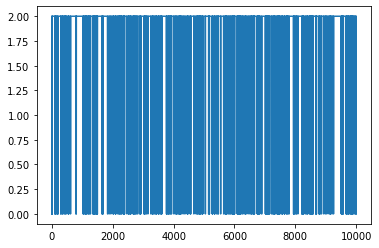

<Figure size 432x288 with 0 Axes>

In [25]:
E, y_go = Montecarlo(T,num_select,MCMC_step)
#print(E)
#print(len(E)==len(y_go))
#print(y_go)
result_df = pd.DataFrame(y_go)
result_df['Energy'] = E
result_df.to_csv("simulated_annealing_trial1210.csv", sep=",") #yが一要素も変わっていない
print(result_df)

E_Xaxis = [i for i in range(len(E))]
plt.plot(E_Xaxis, E)
plt.show()
plt.savefig('0114_numselect1.png')

In [26]:
E0_count = 0
E2_count = 0
for i in range(len(E)):
    if E[i]==0:
        E0_count += 1
    elif E[i]==2:
        E2_count += 1
print(E0_count)
print(E2_count)
print(len(E))
print(E0_count+E2_count==len(E))#エネルギー2...選ぶ特徴量がひとつなのでTrue, Falseがペアで入れ替わっている

776
9223
9999
True


In [27]:
print(E[0]) 
print(E[1])

0
2


### 記録
12/03...温度なし、エラーが取れた

12/10...温度をつけた、結果の表示方法変更

01/05 👇変更を適用し忘れていたため起こったエラー

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-12-778dc39d918c> in <module>
----> 1 E, y_go = Montecarlo(T,num_select,MCMC_step)
      2 #print(E)
      3 #print(len(E)==len(y_go))
      4 #print(y_go)
      5 result_df = pd.DataFrame(y_go)

<ipython-input-11-8d8129039bcd> in Montecarlo(T, num_select, MCMC_step)
      5     ori_y = y #元のデータのyを代入
      6     ori_y_list = ori_y.values.tolist()
----> 7     each_energy(mask, ori_y) #比較対象は自身なのですべての要素が同じ⇒len(mask)= 20
      8     E.append(0) #each_energy(mask, ori_y) - each_energy(mask, ori_y) = 0
      9     y_go.append(ori_y_list) #元のyを格納

TypeError: each_energy() takes 1 positional argument but 2 were given
```

###  結果
* yに変化なし…```MCMC_step=1000, 5000, 10000```のとき

* ```
 else:
     E.append(E_now)   
     y_list = y.values.tolist()      
     y_go.append(y_list)
  ```
  と改善したら良くなった


* マイナスのエネルギーはおかしい
  * ```each_energy(mask_new, y)```に問題があるだろう